<a href="https://colab.research.google.com/github/ankersp/thesis/blob/main/Finetuning_of_climateBERT_commitment_and_ESGBERT_action.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading libraries

In [1]:
!pip install transformers
!pip install accelerate
!pip install datasets

# standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split

import datasets
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline # for using the models
from transformers import DataCollatorWithPadding, TrainingArguments, Trainer, EarlyStoppingCallback # functions for the training

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


# ClimateBERT-commitment

In [12]:
# Load the model as usual
tokenizer_name = "climatebert/distilroberta-base-climate-commitment"
model_name = "climatebert/distilroberta-base-climate-commitment"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, max_len=512)
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer)

Device set to use cuda:0


In [13]:
# Use the dataset from the paper that is available on HuggingFace
dataset_name = "climatebert/climate_commitments_actions"
hf_dataset = datasets.load_dataset(dataset_name)
data = hf_dataset["train"].to_pandas()[["text", "label"]]

# traintest split using the non-preprocessed data (df)
# Use stratify to keep the label distribution of the original dataset
# Use random_state to always have the same outcome of the split
train, test = train_test_split(data, test_size=.2, stratify=data["label"], random_state=42)
train, val = train_test_split(train, test_size=.2, stratify=train["label"], random_state=42)

In [8]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [18]:
# costum Config
class Config:
  model = 'climatebert/distilroberta-base-climate-f' # the model we want to fine-tune
  tokenizer = 'climatebert/distilroberta-base-climate-f' # the used tokenizer that transforms text to machine-readable bits
  # define classification task
  task = "label" # take a look at the dataset (below): the column with the labels is called "env"
  steps = 20 # after how many steps of training do I want the model to be evaluated
  epochs = 5 # how often will the dataset run through the model
  batch_size = 16 # how many single datapoint (i.e. sentences)
  learning_rate = 5e-5 # how "fast" should the model learn the data

  # not necessary to understand but google these concepts if you feel like it
  gradient_accumulation = 2
  warmup_ratio = 0.1
  weight_decay = 0.1
  patience = 3
  device = 'cuda'

In [19]:
def finetuneModel(Config, train, val):
  # Tokenizer
  # preparing the inputs for a model
  tokenizer = AutoTokenizer.from_pretrained(Config.tokenizer)
  def tokenize(batch):
      tokens = tokenizer(batch['text'], truncation=True, max_length=512)
      tokens['labels'] = batch['labels']
      return tokens

  # Data Collator
  # helps to form a batch of dataset objects
  data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  # Fill in training arguments from Config
  training_args = TrainingArguments(
      output_dir="./",
      overwrite_output_dir = False,
      evaluation_strategy="steps",
      logging_strategy="steps",
      logging_steps=Config.steps,
      eval_steps=Config.steps,
      num_train_epochs=Config.epochs,
      per_device_train_batch_size=Config.batch_size,
      per_device_eval_batch_size=Config.batch_size,
      learning_rate=Config.learning_rate,
      weight_decay=Config.weight_decay,
      gradient_accumulation_steps=Config.gradient_accumulation,
      warmup_ratio=Config.warmup_ratio,
      metric_for_best_model='eval_f1', # eval_f1
      load_best_model_at_end=True,
      )

  # Evaluation metrics
  # we want accuracy, f1, precision and recall as our metrics for evaluation
  def compute_metrics(pred):
      labels = pred.label_ids
      preds = pred.predictions.argmax(-1)
      precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
      acc = accuracy_score(labels, preds)
      return {
          'accuracy': acc,
          'f1': f1,
          'precision': precision,
          'recall': recall
      }

  # model inititialisation
  # we use the base model of Environmental-BERT
  model = AutoModelForSequenceClassification.from_pretrained(Config.model, num_labels=2)

  # HuggingFace Dataset structure
  # create a datastructure that the HuggingFace model can read
  train_dict = {'text': train["text"], 'labels': train[Config.task]}
  val_dict = {'text': val["text"], 'labels': val[Config.task]}
  train_dataset = datasets.Dataset.from_dict(train_dict)
  val_dataset = datasets.Dataset.from_dict(val_dict)
  # tokenize
  train_dataset = train_dataset.map(tokenize, num_proc=1, batched=True, remove_columns=["text"])
  val_dataset = val_dataset.map(tokenize, num_proc=1, batched=True, remove_columns=["text"])

  # Trainer
  # object that combines all prior steps
  trainer = Trainer(
      model,
      training_args,
      train_dataset=train_dataset,
      eval_dataset=val_dataset,
      data_collator=data_collator,
      tokenizer=tokenizer,
      compute_metrics=compute_metrics,
      callbacks=[EarlyStoppingCallback(early_stopping_patience=Config.patience)]
  )

  # start the model training
  trainer.train()

  # return the final model
  return model, tokenizer

In [20]:
# actual training
model, tokenizer = finetuneModel(Config, train, val)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at climatebert/distilroberta-base-climate-f and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1040 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

<ipython-input-19-96a2a190f89a>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
20,1.333100,0.596883,0.575000,0.365079,0.287500,0.500000
40,0.825600,0.277102,0.862500,0.860737,0.858894,0.865090
60,0.703900,0.257120,0.887500,0.886364,0.884712,0.892583
80,0.450200,0.258997,0.906250,0.905419,0.904006,0.912724
100,0.399000,0.249408,0.900000,0.897698,0.897698,0.897698
120,0.313000,0.213890,0.900000,0.898073,0.896825,0.899616
140,0.183700,0.266340,0.918750,0.918030,0.916523,0.925512
160,0.117400,0.267110,0.906250,0.904909,0.902771,0.908887


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Could not locate the best model at ./checkpoint-140/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


Device set to use cuda:0


Evaluation of climatebert/distilroberta-base-climate-f
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       115
           1       0.85      0.89      0.87        85

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.89      0.89      0.89       200

Metrics saved to: /content/drive/My Drive/KU/kandidat/speciale/R/finetuned_climatebert_action_metrics.csv


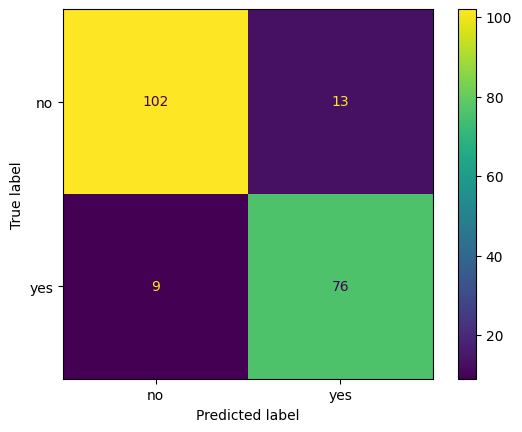

In [21]:
from transformers import pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create a pipeline
action_pipe = pipeline(
    'text-classification',
    model=model,
    tokenizer=tokenizer,
    device=0  # Use GPU if available; set to -1 for CPU
)

# Prepare test data
text = test["text"].to_numpy().astype(str)
labels = test[Config.task].to_numpy()

# Map model outputs to numerical labels
def label_to_num(inp):
    if inp == 'LABEL_0':
        return 0
    elif inp == 'LABEL_1':
        return 1

# Use transformer for predictions
def useTransformer(arr, classifier):
    arr_2 = classifier([x for x in arr])  # Classify each text
    res = [label_to_num(x['label']) for x in arr_2]
    return res

# Evaluate predictions, display metrics, and save them
def evaluate_and_save(labels, pred, name, save_path):
    print("Evaluation of " + name)

    # Generate classification report
    report_dict = classification_report(labels, pred, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()

    # Display metrics
    print(classification_report(labels, pred))

    # Save metrics to Google Drive
    report_df.to_csv(save_path)
    print(f"Metrics saved to: {save_path}")

    # Display confusion matrix
    confMat = confusion_matrix(labels, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=confMat, display_labels=["no", "yes"])
    disp.plot()
    plt.show()

# Predict
pred = useTransformer(text, action_pipe)

# Save metrics to Google Drive
metrics_save_path = "/content/drive/My Drive/KU/kandidat/speciale/R/baseline_climatebert_action_metrics.csv"
evaluate_and_save(labels, pred, Config.model, metrics_save_path)


## Fine-tuning

In [ ]:
import pandas as pd

# Specify the path to the file in Google Drive
file_path = '/content/drive/My Drive/KU/kandidat/speciale/R/env_annotated_500_train.csv'
annotated_data = pd.read_csv(file_path)

print(annotated_data.columns)


Index(['id', 'text', 'Action..1.yes', 'Specific..1...yes',
       'Sentiment..risk...0..neutral..1..opportunity...2'],
      dtype='object')


In [ ]:
# Rename the column
annotated_data.rename(columns={"Action..1.yes": "label"}, inplace=True)

# Validate renaming
print("Updated column names:", annotated_data.columns)

# Select relevant columns
annotated_data = annotated_data[["text", "label"]]

# Append to training data
train = pd.concat([train, annotated_data], ignore_index=True)

# Optional: Shuffle the combined dataset
train = train.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the updated training data
print(train.head())
print(f"Training data size: {len(train)}")

Updated column names: Index(['id', 'text', 'label', 'Specific..1...yes',
       'Sentiment..risk...0..neutral..1..opportunity...2'],
      dtype='object')
                                                text  label
0  We strengthened our commitment to responsible ...      1
1  Investec group including Investec Asset Manage...      0
2  Unfortunately, this progress has come at a cos...      0
3  With regards to opportunities, decarbonising t...      0
4  Environmental and social responsibility In 202...      1
Training data size: 1040


In [ ]:
# actual training
model, tokenizer = finetuneModel(Config, train, val)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at climatebert/distilroberta-base-climate-f and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1040 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

<ipython-input-19-96a2a190f89a>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
20,1.333100,0.596883,0.575000,0.365079,0.287500,0.500000
40,0.825600,0.277102,0.862500,0.860737,0.858894,0.865090
60,0.703900,0.257120,0.887500,0.886364,0.884712,0.892583
80,0.450200,0.258997,0.906250,0.905419,0.904006,0.912724
100,0.399000,0.249408,0.900000,0.897698,0.897698,0.897698
120,0.313000,0.213890,0.900000,0.898073,0.896825,0.899616
140,0.183700,0.266340,0.918750,0.918030,0.916523,0.925512
160,0.117400,0.267110,0.906250,0.904909,0.902771,0.908887


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Could not locate the best model at ./checkpoint-140/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


Device set to use cuda:0


Evaluation of climatebert/distilroberta-base-climate-f
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       115
           1       0.85      0.89      0.87        85

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.89      0.89      0.89       200

Metrics saved to: /content/drive/My Drive/KU/kandidat/speciale/R/finetuned_climatebert_action_metrics.csv


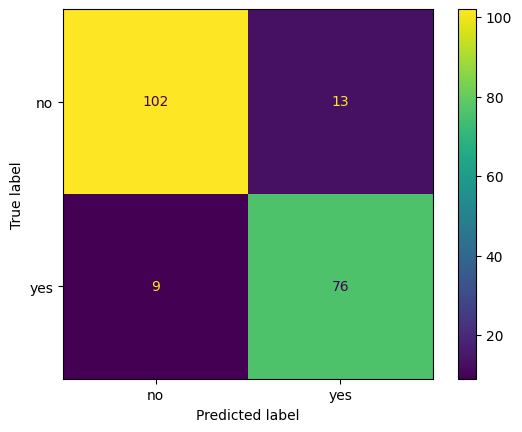

In [ ]:
from transformers import pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create a pipeline
action_pipe = pipeline(
    'text-classification',
    model=model,
    tokenizer=tokenizer,
    device=0  # Use GPU if available; set to -1 for CPU
)

# Prepare test data
text = test["text"].to_numpy().astype(str)
labels = test[Config.task].to_numpy()

# Map model outputs to numerical labels
def label_to_num(inp):
    if inp == 'LABEL_0':
        return 0
    elif inp == 'LABEL_1':
        return 1

# Use transformer for predictions
def useTransformer(arr, classifier):
    arr_2 = classifier([x for x in arr])  # Classify each text
    res = [label_to_num(x['label']) for x in arr_2]
    return res

# Evaluate predictions, display metrics, and save them
def evaluate_and_save(labels, pred, name, save_path):
    print("Evaluation of " + name)

    # Generate classification report
    report_dict = classification_report(labels, pred, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()

    # Display metrics
    print(classification_report(labels, pred))

    # Save metrics to Google Drive
    report_df.to_csv(save_path)
    print(f"Metrics saved to: {save_path}")

    # Display confusion matrix
    confMat = confusion_matrix(labels, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=confMat, display_labels=["no", "yes"])
    disp.plot()
    plt.show()

# Predict
pred = useTransformer(text, action_pipe)

# Save metrics to Google Drive
metrics_save_path = "/content/drive/My Drive/KU/kandidat/speciale/R/finetuned_climatebert_action_metrics.csv"
evaluate_and_save(labels, pred, Config.model, metrics_save_path)


In [22]:
# Save model and tokenizer
model.save_pretrained("finetuned_climatebert_action_model")  # Note: No './' at the start
tokenizer.save_pretrained("finetuned_climatebert_action_model")


('finetuned_climatebert_action_model/tokenizer_config.json',
 'finetuned_climatebert_action_model/special_tokens_map.json',
 'finetuned_climatebert_action_model/vocab.json',
 'finetuned_climatebert_action_model/merges.txt',
 'finetuned_climatebert_action_model/added_tokens.json',
 'finetuned_climatebert_action_model/tokenizer.json')

In [24]:
!mv /content/finetuned_climatebert_action_model /content/drive/My\ Drive/KU/kandidat/speciale/R/

# ESGBERT-action

In [2]:
# Load the model as usual
tokenizer_name = "ESGBERT/EnvironmentalBERT-action"
model_name = "ESGBERT/EnvironmentalBERT-action"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, max_len=512)
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/805 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/351 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Device set to use cuda:0


In [3]:
# Use the dataset from the paper that is available on HuggingFace
dataset_name = "ESGBERT/action_500"
hf_dataset = datasets.load_dataset(dataset_name)
data = hf_dataset["train"].to_pandas()[["text", "action"]]

# traintest split using the non-preprocessed data (df)
# Use stratify to keep the label distribution of the original dataset
# Use random_state to always have the same outcome of the split
train, test = train_test_split(data, test_size=.2, stratify=data["action"], random_state=42)
train, val = train_test_split(train, test_size=.2, stratify=train["action"], random_state=42)

README.md:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

action_500.csv:   0%|          | 0.00/95.8k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/500 [00:00<?, ? examples/s]

In [4]:
# costum Config
class Config:
  model = 'ESGBERT/EnvironmentalBERT-base' # the model we want to fine-tune
  tokenizer = 'ESGBERT/EnvironmentalBERT-base' # the used tokenizer that transforms text to machine-readable bits
  # define classification task
  task = "action" # take a look at the dataset (below): the column with the labels is called "env"
  steps = 20 # after how many steps of training do I want the model to be evaluated
  epochs = 5 # how often will the dataset run through the model
  batch_size = 16 # how many single datapoint (i.e. sentences)
  learning_rate = 5e-5 # how "fast" should the model learn the data

  gradient_accumulation = 2
  warmup_ratio = 0.1
  weight_decay = 0.1
  patience = 3
  device = 'cuda'

In [5]:
def finetuneModel(Config, train, val):
  # Tokenizer
  # preparing the inputs for a model
  tokenizer = AutoTokenizer.from_pretrained(Config.tokenizer)
  def tokenize(batch):
      tokens = tokenizer(batch['text'], truncation=True, max_length=512)
      tokens['labels'] = batch['labels']
      return tokens

  # Data Collator
  # helps to form a batch of dataset objects
  data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  # Fill in training arguments from Config
  training_args = TrainingArguments(
      output_dir="./",
      overwrite_output_dir = False,
      evaluation_strategy="steps",
      logging_strategy="steps",
      logging_steps=Config.steps,
      eval_steps=Config.steps,
      num_train_epochs=Config.epochs,
      per_device_train_batch_size=Config.batch_size,
      per_device_eval_batch_size=Config.batch_size,
      learning_rate=Config.learning_rate,
      weight_decay=Config.weight_decay,
      gradient_accumulation_steps=Config.gradient_accumulation,
      warmup_ratio=Config.warmup_ratio,
      metric_for_best_model='eval_f1', # eval_f1
      load_best_model_at_end=True,
      )

  # Evaluation metrics
  # we want accuracy, f1, precision and recall as our metrics for evaluation
  def compute_metrics(pred):
      labels = pred.label_ids
      preds = pred.predictions.argmax(-1)
      precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
      acc = accuracy_score(labels, preds)
      return {
          'accuracy': acc,
          'f1': f1,
          'precision': precision,
          'recall': recall
      }

  # model inititialisation
  # we use the base model of Environmental-BERT
  model = AutoModelForSequenceClassification.from_pretrained(Config.model, num_labels=2)

  # HuggingFace Dataset structure
  # create a datastructure that the HuggingFace model can read
  train_dict = {'text': train["text"], 'labels': train[Config.task]}
  val_dict = {'text': val["text"], 'labels': val[Config.task]}
  train_dataset = datasets.Dataset.from_dict(train_dict)
  val_dataset = datasets.Dataset.from_dict(val_dict)
  # tokenize
  train_dataset = train_dataset.map(tokenize, num_proc=1, batched=True, remove_columns=["text"])
  val_dataset = val_dataset.map(tokenize, num_proc=1, batched=True, remove_columns=["text"])

  # Trainer
  # object that combines all prior steps
  trainer = Trainer(
      model,
      training_args,
      train_dataset=train_dataset,
      eval_dataset=val_dataset,
      data_collator=data_collator,
      tokenizer=tokenizer,
      compute_metrics=compute_metrics,
      callbacks=[EarlyStoppingCallback(early_stopping_patience=Config.patience)]
  )

  # start the model training
  trainer.train()

  # return the final model
  return model, tokenizer

In [6]:
# actual training
model, tokenizer = finetuneModel(Config, train, val)

tokenizer_config.json:   0%|          | 0.00/351 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ESGBERT/EnvironmentalBERT-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

<ipython-input-5-96a2a190f89a>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
20,1.285800,0.540246,0.750000,0.733333,0.754986,0.728900
40,0.605100,0.299113,0.862500,0.860737,0.858894,0.865090


Could not locate the best model at ./checkpoint-40/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


Device set to use cuda:0


Evaluation of ESGBERT/EnvironmentalBERT-base
              precision    recall  f1-score   support

           0       0.85      0.93      0.89        57
           1       0.89      0.79      0.84        43

    accuracy                           0.87       100
   macro avg       0.87      0.86      0.87       100
weighted avg       0.87      0.87      0.87       100

Metrics saved to: /content/drive/My Drive/KU/kandidat/speciale/R/baseline_esgbert_action_metrics.csv


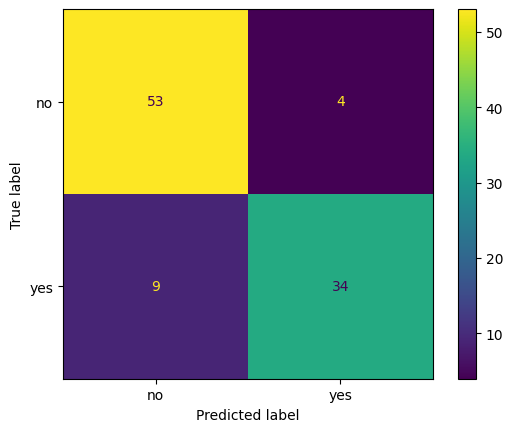

In [9]:
from transformers import pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create a pipeline
action_pipe = pipeline(
    'text-classification',
    model=model,
    tokenizer=tokenizer,
    device=0  # Use GPU if available; set to -1 for CPU
)

# Prepare test data
text = test["text"].to_numpy().astype(str)
labels = test[Config.task].to_numpy()

# Map model outputs to numerical labels
def label_to_num(inp):
    if inp == 'LABEL_0':
        return 0
    elif inp == 'LABEL_1':
        return 1

# Use transformer for predictions
def useTransformer(arr, classifier):
    arr_2 = classifier([x for x in arr])  # Classify each text
    res = [label_to_num(x['label']) for x in arr_2]
    return res

# Evaluate predictions, display metrics, and save them
def evaluate_and_save(labels, pred, name, save_path):
    print("Evaluation of " + name)

    # Generate classification report
    report_dict = classification_report(labels, pred, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()

    # Display metrics
    print(classification_report(labels, pred))

    # Save metrics to Google Drive
    report_df.to_csv(save_path)
    print(f"Metrics saved to: {save_path}")

    # Display confusion matrix
    confMat = confusion_matrix(labels, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=confMat, display_labels=["no", "yes"])
    disp.plot()
    plt.show()

# Predict
pred = useTransformer(text, action_pipe)

# Save metrics to Google Drive
metrics_save_path = "/content/drive/My Drive/KU/kandidat/speciale/R/baseline_esgbert_action_metrics.csv"
evaluate_and_save(labels, pred, Config.model, metrics_save_path)


## Fine-tuning

In [10]:
import pandas as pd

# Specify the path to the file in Google Drive
file_path = '/content/drive/My Drive/KU/kandidat/speciale/R/env_annotated_500_train.csv'
annotated_data = pd.read_csv(file_path)

print(annotated_data.columns)


Index(['id', 'text', 'Action..1.yes', 'Specific..1...yes',
       'Sentiment..risk...0..neutral..1..opportunity...2', 'doc_id', 'CVR',
       'Year'],
      dtype='object')


In [11]:
# Rename the column
annotated_data.rename(columns={"Action..1.yes": "action"}, inplace=True)

# Validate renaming
print("Updated column names:", annotated_data.columns)

# Select relevant columns
annotated_data = annotated_data[["text", "action"]]

# Append to training data
train = pd.concat([train, annotated_data], ignore_index=True)

# Optional: Shuffle the combined dataset
train = train.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the updated training data
print(train.head())
print(f"Training data size: {len(train)}")

Updated column names: Index(['id', 'text', 'action', 'Specific..1...yes',
       'Sentiment..risk...0..neutral..1..opportunity...2', 'doc_id', 'CVR',
       'Year'],
      dtype='object')
                                                text  action
0  Act- Human rights- Social and employee relatio...       0
1  In 2007 we also signed up to the Lloyd’s Clima...       1
2  A final recommendation is made to the Board by...       0
3  As individuals and organisations, we must aim ...       0
4  Involve and influence company employees for th...       0
Training data size: 720


In [12]:
# actual training
model, tokenizer = finetuneModel(Config, train, val)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ESGBERT/EnvironmentalBERT-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/720 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

<ipython-input-5-96a2a190f89a>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
20,1.304100,0.660264,0.575000,0.365079,0.287500,0.500000
40,0.904900,0.607580,0.737500,0.703756,0.773512,0.702685
60,0.503900,0.409129,0.787500,0.781736,0.783043,0.780691
80,0.341800,0.406583,0.837500,0.831579,0.837722,0.828005
100,0.225400,0.410668,0.825000,0.824891,0.835859,0.840153


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Could not locate the best model at ./checkpoint-80/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


Device set to use cuda:0


Evaluation of ESGBERT/EnvironmentalBERT-base
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        57
           1       0.83      0.81      0.82        43

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

Metrics saved to: /content/drive/My Drive/KU/kandidat/speciale/R/finetuned_esgbert_action_metrics.csv


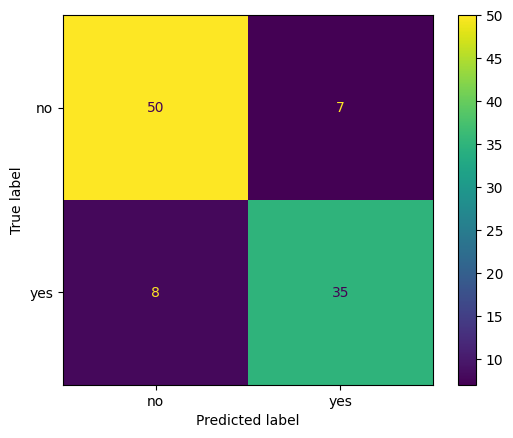

In [13]:
from transformers import pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create a pipeline
action_pipe = pipeline(
    'text-classification',
    model=model,
    tokenizer=tokenizer,
    device=0  # Use GPU if available; set to -1 for CPU
)

# Prepare test data
text = test["text"].to_numpy().astype(str)
labels = test[Config.task].to_numpy()

# Map model outputs to numerical labels
def label_to_num(inp):
    if inp == 'LABEL_0':
        return 0
    elif inp == 'LABEL_1':
        return 1

# Use transformer for predictions
def useTransformer(arr, classifier):
    arr_2 = classifier([x for x in arr])  # Classify each text
    res = [label_to_num(x['label']) for x in arr_2]
    return res

# Evaluate predictions, display metrics, and save them
def evaluate_and_save(labels, pred, name, save_path):
    print("Evaluation of " + name)

    # Generate classification report
    report_dict = classification_report(labels, pred, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()

    # Display metrics
    print(classification_report(labels, pred))

    # Save metrics to Google Drive
    report_df.to_csv(save_path)
    print(f"Metrics saved to: {save_path}")

    # Display confusion matrix
    confMat = confusion_matrix(labels, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=confMat, display_labels=["no", "yes"])
    disp.plot()
    plt.show()

# Predict
pred = useTransformer(text, action_pipe)

# Save metrics to Google Drive
metrics_save_path = "/content/drive/My Drive/KU/kandidat/speciale/R/finetuned_esgbert_action_metrics.csv"
evaluate_and_save(labels, pred, Config.model, metrics_save_path)


In [14]:
# Save model and tokenizer
model.save_pretrained("finetuned_esgbert_action_model")  # Note: No './' at the start
tokenizer.save_pretrained("finetuned_esgbert_action_model")


('finetuned_esgbert_action_model/tokenizer_config.json',
 'finetuned_esgbert_action_model/special_tokens_map.json',
 'finetuned_esgbert_action_model/vocab.json',
 'finetuned_esgbert_action_model/merges.txt',
 'finetuned_esgbert_action_model/added_tokens.json',
 'finetuned_esgbert_action_model/tokenizer.json')

In [16]:
!mv /content/finetuned_esgbert_action_model /content/drive/My\ Drive/KU/kandidat/speciale/R/